In [1]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import logging
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split

# Load utility functions from cloned repository
from src.loadData import GraphDataset
from src.utils import set_seed
from src.models import GNN
import argparse

# Set the random seed
set_seed()


In [2]:
def add_zeros(data):
    data.x = torch.zeros(data.num_nodes, dtype=torch.long)
    return data

In [ ]:
dataset_name = "C"

train_path = f"./datasets/{dataset_name}/train.json.gz"
script_dir = os.getcwd()

train_dir_name = os.path.basename(os.path.dirname(train_path))
logs_folder = os.path.join(script_dir, "logs", train_dir_name)
log_file = os.path.join(logs_folder, "training.log")
os.makedirs(os.path.dirname(log_file), exist_ok=True)
logging.basicConfig(
    filename=log_file, level=logging.INFO, format="%(asctime)s - %(message)s"
)
logging.getLogger().addHandler(logging.StreamHandler())
checkpoint_path = os.path.join(
    script_dir, "checkpoints", f"model_{train_dir_name}_best.pth"
)
checkpoints_folder = os.path.join(script_dir, "checkpoints", train_dir_name)
os.makedirs(checkpoints_folder, exist_ok=True)


In [4]:
# full_dataset = GraphDataset(train_path, transform=add_zeros)
# val_size = int(0.2 * len(full_dataset))
# train_size = len(full_dataset) - val_size


# generator = torch.Generator().manual_seed(12)
# train_dataset, val_dataset = random_split(
#     full_dataset, [train_size, val_size], generator=generator
# )

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # type: ignore
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # type: ignore


In [5]:
import torch
import matplotlib.pyplot as plt

def inspect_graphs(dataset, title="Dataset Overview"):
    num_nodes_list = []
    num_edges_list = []
    has_self_loops = 0
    has_isolated_nodes = 0

    for data in dataset:
        num_nodes_list.append(data.num_nodes)
        num_edges_list.append(data.edge_index.size(1))

        if torch.any(data.edge_index[0] == data.edge_index[1]):
            has_self_loops += 1

        degrees = torch.bincount(data.edge_index[0], minlength=data.num_nodes)
        if (degrees == 0).any():
            has_isolated_nodes += 1

    print(f"\n--- {title} ---")
    print(f"Graphs: {len(dataset)}")
    print(f"Avg #nodes: {torch.tensor(num_nodes_list).float().mean():.2f}")
    print(f"Avg #edges: {torch.tensor(num_edges_list).float().mean():.2f}")
    print(f"Graphs with self-loops: {has_self_loops}")
    print(f"Graphs with isolated nodes: {has_isolated_nodes}")

    # Optional histograms
    plt.hist(num_nodes_list, bins=30, alpha=0.6, label="nodes")
    plt.hist(num_edges_list, bins=30, alpha=0.6, label="edges")
    plt.legend()
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("Frequency")
    plt.show()



--- Before Cleaning ---
Graphs: 7680
Avg #nodes: 243.31
Avg #edges: 4459.99
Graphs with self-loops: 0
Graphs with isolated nodes: 0


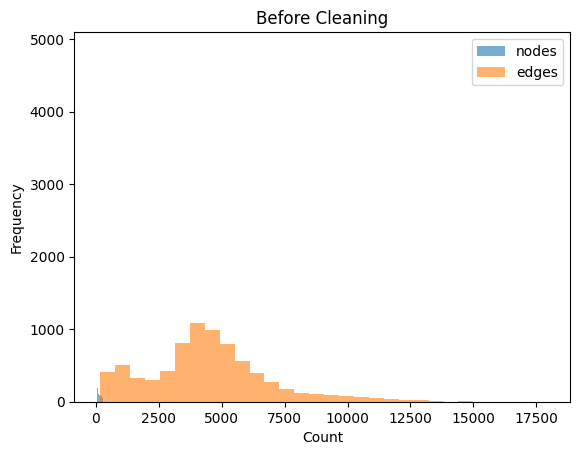

In [6]:
raw_dataset = GraphDataset(train_path,transform=add_zeros)
inspect_graphs(raw_dataset, "Before Cleaning")



--- After Cleaning ---
Graphs: 7680
Avg #nodes: 243.31
Avg #edges: 4459.99
Graphs with self-loops: 0
Graphs with isolated nodes: 0


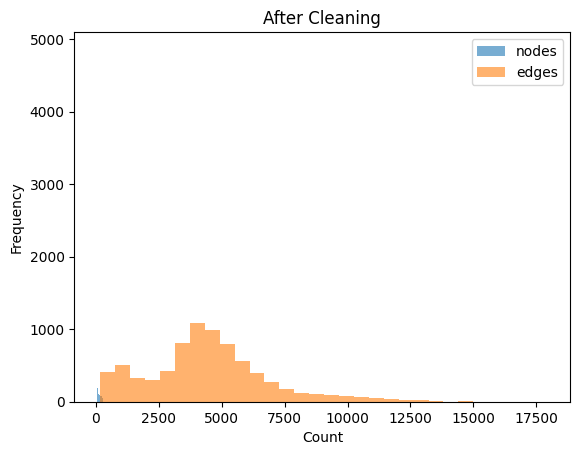

In [7]:
from torch_geometric.transforms import Compose, ToUndirected, RemoveDuplicatedEdges
from torch_geometric.transforms import RemoveSelfLoops, RemoveIsolatedNodes

cleaning_transform = Compose([
    add_zeros,
    RemoveDuplicatedEdges(),
    ToUndirected(),
    RemoveSelfLoops(),
    RemoveIsolatedNodes(),
])
cleaned_dataset = GraphDataset(train_path, transform=cleaning_transform)
inspect_graphs(cleaned_dataset, "After Cleaning")


In [8]:
def compare_graphs(raw_dataset, cleaned_dataset):
    for i in range(len(raw_dataset)):
        raw = raw_dataset[i]
        cleaned = cleaned_dataset[i]

        if raw.edge_index.size(1) != cleaned.edge_index.size(1):
            print(f"Graph {i} had edge count change: {raw.edge_index.size(1)} → {cleaned.edge_index.size(1)}")
        if raw.num_nodes != cleaned.num_nodes:
            print(f"Graph {i} had node count change: {raw.num_nodes} → {cleaned.num_nodes}")


In [9]:
compare_graphs(raw_dataset,cleaned_dataset)

In [10]:
def plot_node_edge_scatter(dataset, title=""):
    num_nodes_list = []
    num_edges_list = []
    
    for data in dataset:
        num_nodes_list.append(data.num_nodes)
        num_edges_list.append(data.edge_index.size(1))

    plt.figure(figsize=(6, 5))
    plt.scatter(num_nodes_list, num_edges_list, alpha=0.3, s=10)
    plt.xlabel("# Nodes")
    plt.ylabel("# Edges")
    plt.title(title)
    plt.grid(True)
    plt.show()


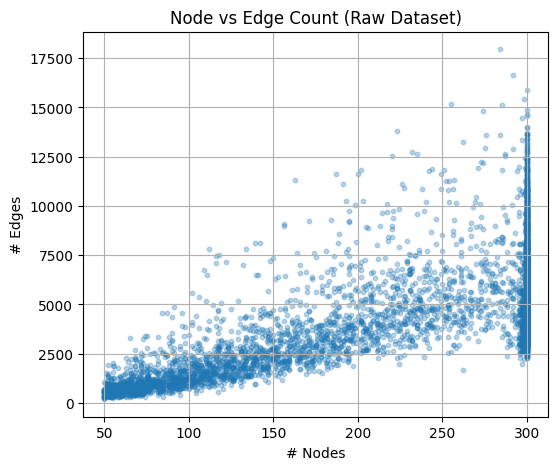

In [11]:
plot_node_edge_scatter(raw_dataset, "Node vs Edge Count (Raw Dataset)")


In [12]:
import torch
from collections import Counter
import matplotlib.pyplot as plt

def plot_label_distribution(dataset):
    labels = [data.y.item() for data in dataset if data.y is not None]
    label_counts = Counter(labels)

    print(f"Number of classes: {len(label_counts)}")
    print(f"Top 10 class frequencies:")
    for cls, count in label_counts.most_common(10):
        print(f"Class {cls}: {count} samples")

    plt.bar(label_counts.keys(), label_counts.values())
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title("Label Distribution")
    plt.show()


Number of classes: 6
Top 10 class frequencies:
Class 2: 3136 samples
Class 1: 1480 samples
Class 4: 1144 samples
Class 3: 800 samples
Class 5: 720 samples
Class 0: 400 samples


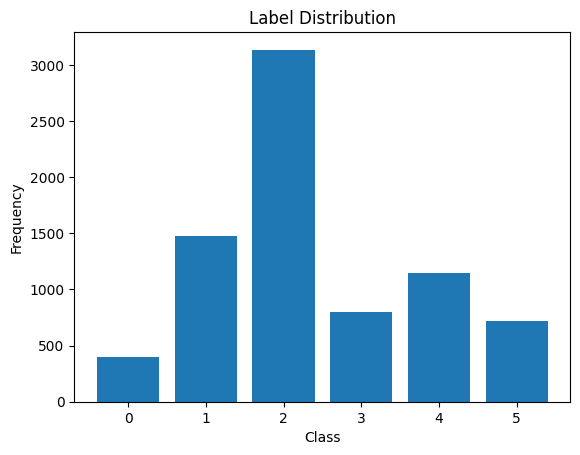

In [13]:
plot_label_distribution(raw_dataset)

In [2]:
import gzip
import json
from collections import defaultdict

def collect_label_votes():
    label_votes = defaultdict(list)
    dataset_names = ["A","B","C","D"]
    for dataset_name in dataset_names:
        filename = f"./datasets/{dataset_name}/train.json.gz"
        print(f"Reading from: {filename}")
        with gzip.open(filename, "rt", encoding="utf-8") as f:
            graphs = json.load(f)
            for i, graph in enumerate(graphs):
                y = graph["y"][0]
                label_votes[i].append(y)  # assumes same ordering across datasets

    return label_votes


In [4]:
label_votes = collect_label_votes()

Reading from: ./datasets/A/train.json.gz
Reading from: ./datasets/B/train.json.gz
Reading from: ./datasets/C/train.json.gz
Reading from: ./datasets/D/train.json.gz


In [5]:
from collections import Counter

def compute_consensus_labels(label_votes):
    consensus_labels = {}
    label_confidence = {}

    for graph_id, votes in label_votes.items():
        vote_counts = Counter(votes)
        top_label, top_count = vote_counts.most_common(1)[0]
        consensus_labels[graph_id] = top_label
        label_confidence[graph_id] = top_count / len(votes)

    return consensus_labels, label_confidence


In [ ]:
consensus_labels, label_confidence= compute_consensus_labels(label_votes)